In [37]:
from sentence_transformers import SentenceTransformer
from datasets import load_dataset

base_model_name_or_path = "bert-base-multilingual-uncased"
# base_model_name_or_path = "Snowflake/snowflake-arctic-embed-m"
# base_model_name_or_path = "mixedbread-ai/mxbai-embed-large-v1"
tuned_model_name_or_path = "output/enbeddrus-en-ru-2024-05-19_18-46-49" # domain
# tuned_model_name_or_path = "output/enbeddrus-en-ru-2024-05-20_11-30-48" # parallel

dataset_name = "evilfreelancer/opus-php-en-ru-cleaned"

# Load models
base_model = SentenceTransformer(base_model_name_or_path)
tuned_model = SentenceTransformer(tuned_model_name_or_path)

# Load dataset
dataset = load_dataset(dataset_name)

# Split dataset
english_phrases = dataset['eval']['English']
russian_phrases = dataset['eval']['Russian']

# Extract embeddings from base model
base_eng_embedding = base_model.encode(english_phrases)
base_rus_embedding = base_model.encode(russian_phrases)

# Extract embeddings from tuned model
tuned_eng_embedding = tuned_model.encode(english_phrases)
tuned_rus_embedding = tuned_model.encode(russian_phrases)

No sentence-transformers model found with name bert-base-multilingual-uncased. Creating a new one with MEAN pooling.
/home/pasha/Documents/Repository/gpt/enbeddrus/venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [38]:
import numpy as np

# Функция для расчета косинусного сходства
def cosine_similarity(emb1, emb2):
    dot_product = np.dot(emb1, emb2)
    norm_emb1 = np.linalg.norm(emb1)
    norm_emb2 = np.linalg.norm(emb2)
    return dot_product / (norm_emb1 * norm_emb2)


# Расчет косинусного сходства для базовой и дообученной моделей
base_similarities = []
tuned_similarities = []

for i in range(len(base_eng_embedding)):
    base_similarity = cosine_similarity(base_eng_embedding[i], base_rus_embedding[i])
    tuned_similarity = cosine_similarity(tuned_eng_embedding[i], tuned_rus_embedding[i])

    base_similarities.append(base_similarity)
    tuned_similarities.append(tuned_similarity)

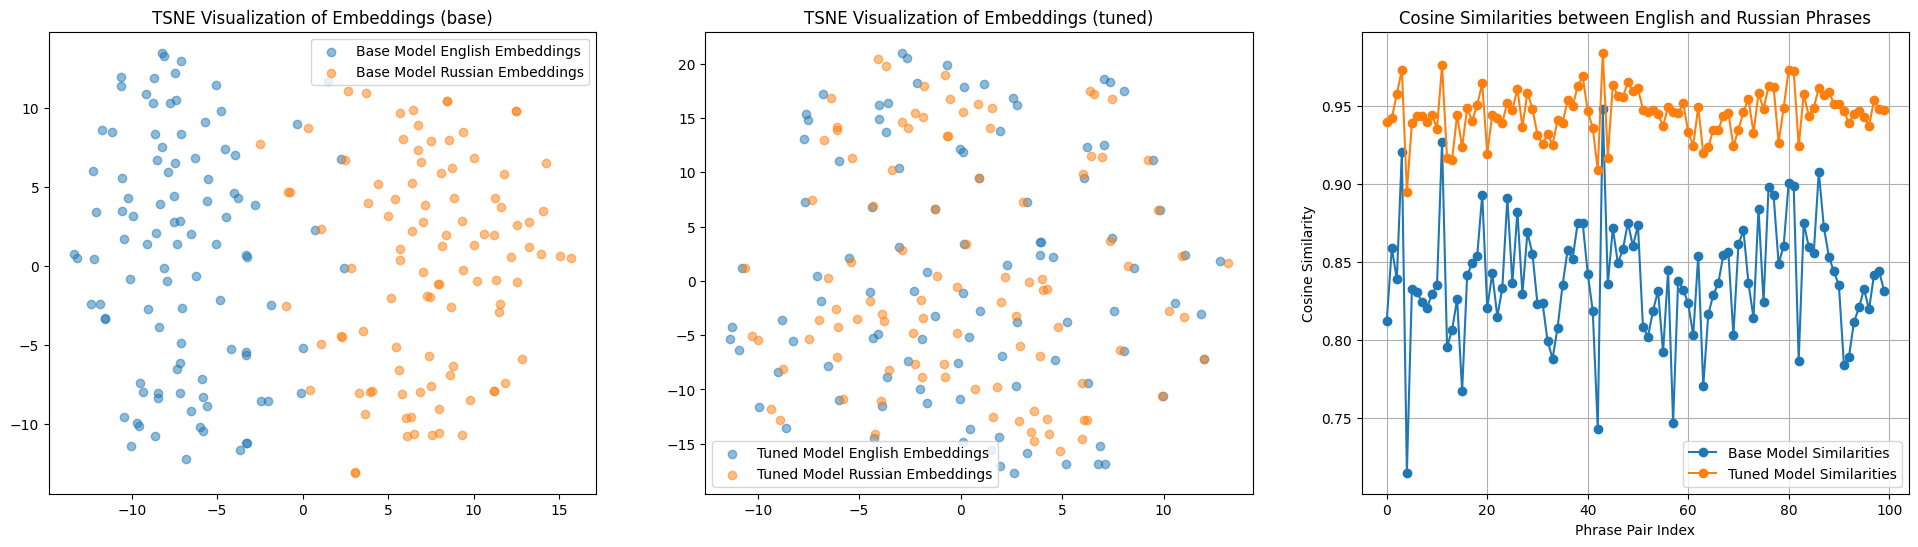

In [39]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Set up the figure and axes
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

# Plot the cosine similarities
axs[2].plot(base_similarities, label='Base Model Similarities', marker='o')
axs[2].plot(tuned_similarities, label='Tuned Model Similarities', marker='o')
axs[2].set_title('Cosine Similarities between English and Russian Phrases')
axs[2].set_xlabel('Phrase Pair Index')
axs[2].set_ylabel('Cosine Similarity')
axs[2].legend()
axs[2].grid(True)

# TSNE visualization of embeddings
tsne = TSNE(n_components=2, random_state=42)

base_embeddings_2d = tsne.fit_transform(np.concatenate((base_eng_embedding, base_rus_embedding)))
tuned_embeddings_2d = tsne.fit_transform(np.concatenate((tuned_eng_embedding, tuned_rus_embedding)))

# Scatter plot of embeddings
axs[1].scatter(
    tuned_embeddings_2d[:len(tuned_eng_embedding), 0],
    tuned_embeddings_2d[:len(tuned_eng_embedding), 1],
    label='Tuned Model English Embeddings', alpha=0.5
)
axs[1].scatter(
    tuned_embeddings_2d[len(tuned_eng_embedding):, 0],
    tuned_embeddings_2d[len(tuned_eng_embedding):, 1],
    label='Tuned Model Russian Embeddings', alpha=0.5
)
axs[1].set_title('TSNE Visualization of Embeddings (tuned)')
axs[1].legend()

axs[0].scatter(
    base_embeddings_2d[:len(base_eng_embedding), 0],
    base_embeddings_2d[:len(base_eng_embedding), 1],
    label='Base Model English Embeddings', alpha=0.5
)
axs[0].scatter(
    base_embeddings_2d[len(base_eng_embedding):, 0],
    base_embeddings_2d[len(base_eng_embedding):, 1],
    label='Base Model Russian Embeddings', alpha=0.5
)
axs[0].set_title('TSNE Visualization of Embeddings (base)')
axs[0].legend()

# Show the figure
plt.show()